# Simple pendulum

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator

Upright Pendulum link

https://www.12000.org/my_notes/cart_motion/report.htm

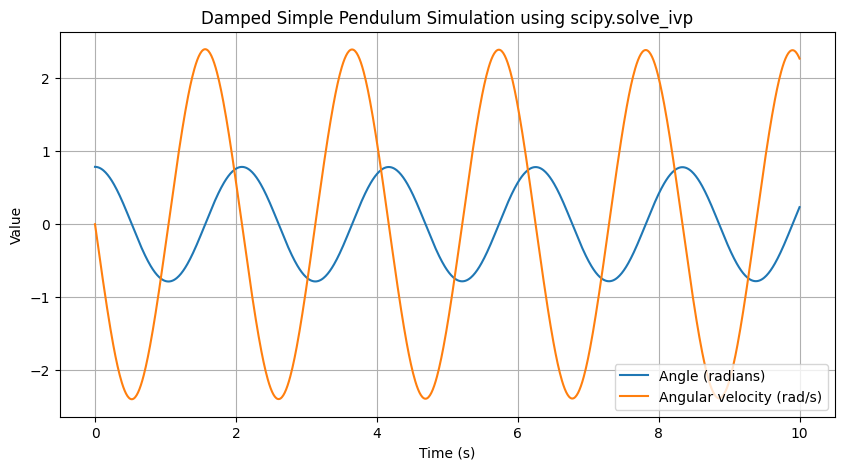

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
IC_df = pd.read_csv("parameters/init_cond_simp_pend.csv")

In [104]:
# IC_df = IC_df[0:2]
IC_df

,x,u,theta,omega
0,0,0,2.35619449,0.80000000
1,-1,0,2.35619449,-0.80000000
2,-10,1,-2.35619449,0.80000000
3,-9,0,-2.35619449,-0.80000000


In [105]:
# Mechanical eEnergy level
0.5*(IC_df["omega"])**2 + 9.81*(1-np.cos(IC_df["theta"]))

0   17.06671752
1   17.06671752
2   17.06671752
3   17.06671752
dtype: float64

In [106]:
params_df = pd.read_csv("parameters/pend_param.csv")
params_df


,l,m_c,m_p
0,1,1,1


In [107]:
g = 9.81   # Acceleration due to gravity (m/s^2)


### Synthesizing data from different ICs

### Synthesizing data from different ICs

In [116]:
L = 5.0
# y_shift = 0.9 * L
# y_shift = 0

# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], 100)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.0         # Damping coefficient
        # Solve the ODEs
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        data_matrix_df_list.append(sol_df[["x", "y"]])
        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df

,x,y
0,3.53553391,3.53553391
1,3.26478266,3.78697692
2,3.02809601,3.97877300
3,2.83013177,4.12193573
4,2.67380740,4.22501526
...,...,...
395,-3.91626245,3.10851868
396,-4.23345932,2.66041767
397,-4.53595028,2.10360524
398,-4.79214791,1.42664585


In [117]:
(3/4)*np.pi

2.356194490192345

<Axes: >

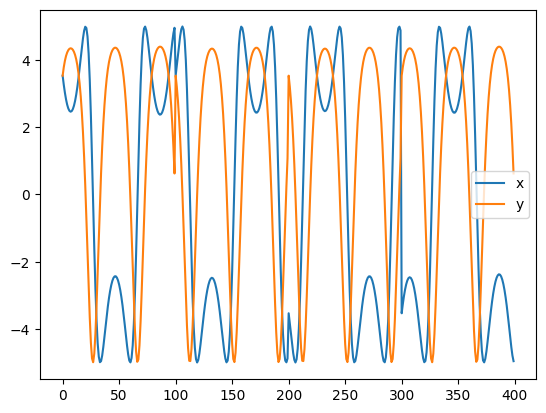

In [110]:
data_matrix_df[["x","y"]].plot()

In [87]:
data_matrix_df_appended["d(theta) /dt"]

KeyError: 'd(theta) /dt'

In [43]:
from copy import deepcopy
new_df = deepcopy(data_matrix_df_appended)

new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]

<Axes: >

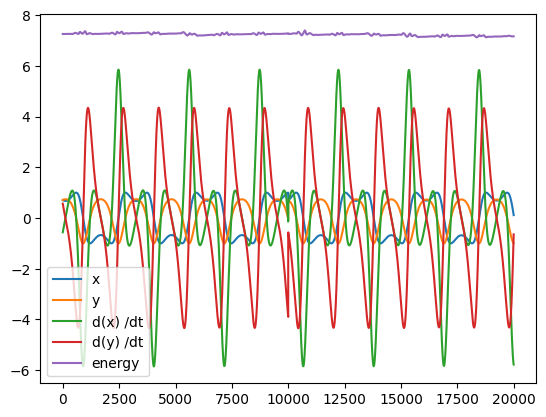

In [44]:
new_df.plot()

### Calculating the derivatives of data

In [118]:
from dae_finder import der_matrix_calculator

In [119]:
delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df_appended

,x,y,d(x) /dt,d(y) /dt
0,3.53553391,3.53553391,-2.68043736,2.48928585
1,3.26478266,3.78697692,-2.34319782,1.89878115
2,3.02809601,3.97877300,-1.95984596,1.41731106
3,2.83013177,4.12193573,-1.54761124,1.02048738
4,2.67380740,4.22501526,-1.12153030,0.68905074
...,...,...,...,...
391,-3.60697466,3.46261950,-3.06194909,-3.50559802
392,-3.91626245,3.10851868,-3.14024900,-4.43620003
393,-4.23345932,2.66041767,-2.99466054,-5.51244303
394,-4.53595028,2.10360524,-2.53635653,-6.70189802


In [30]:
delta_t = t_eval_[1]- t_eval_[0]
data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    derr_matrix = der_matrix_calculator(data_matrix_, delta_t)
    data_matrix_df_list[ind] = pd.concat([data_matrix_.iloc[:-1], derr_matrix], axis=1)

data_matrix_df_appended = pd.concat(data_matrix_df_list, ignore_index=True)
data_matrix_df_appended

,x,y,d(x) /dt,d(y) /dt,d(x) /dt,d(y) /dt,d(d(x) /dt) /dt,d(d(y) /dt) /dt
0,0.70710678,0.70710678,-0.56345766,0.56300899,-0.56345766,0.56300899,4.46049827,-5.34218233
1,0.70654327,0.70766985,-0.55899672,0.55766627,-0.55899672,0.55766627,4.46855717,-5.32703753
2,0.70598421,0.70822757,-0.55452772,0.55233870,-0.55452772,0.55233870,4.47651635,-5.31202025
3,0.70542963,0.70877996,-0.55005075,0.54702615,-0.55005075,0.54702615,4.48437661,-5.29713054
4,0.70487953,0.70932704,-0.54556593,0.54172849,-0.54556593,0.54172849,4.49213873,-5.28236846
...,...,...,...,...,...,...,...,...
19991,0.14291382,-0.98973514,-5.75179725,-0.81348751,-5.75179725,-0.81348751,-5.92391525,33.25428937
19992,0.13716145,-0.99054871,-5.75772176,-0.78022989,-5.75772176,-0.78022989,-5.67172256,33.31091255
19993,0.13140315,-0.99132901,-5.76339405,-0.74691565,-5.76339405,-0.74691565,-5.41872471,33.36505584
19994,0.12563918,-0.99207600,-5.76881332,-0.71354726,-5.76881332,-0.71354726,-5.16494753,33.41670630


In [ ]:
data_matrix_df_appended["x"]

In [122]:
# data_matrix_df = data_matrix_df_appended[["x","y"]]
# data_matrix_df = pd.concat([data_matrix_df, data_matrix_df_appended[["d(u) /dt"]]], axis=1)
data_matrix_df = data_matrix_df_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df

,x,y,d(x) /dt,d(y) /dt
0,3.53553391,3.53553391,-2.68043736,2.48928585
1,3.26478266,3.78697692,-2.34319782,1.89878115
2,3.02809601,3.97877300,-1.95984596,1.41731106
3,2.83013177,4.12193573,-1.54761124,1.02048738
4,2.67380740,4.22501526,-1.12153030,0.68905074
...,...,...,...,...
391,-3.60697466,3.46261950,-3.06194909,-3.50559802
392,-3.91626245,3.10851868,-3.14024900,-4.43620003
393,-4.23345932,2.66041767,-2.99466054,-5.51244303
394,-4.53595028,2.10360524,-2.53635653,-6.70189802


## Forming candiate library

In [113]:
from sklearn.preprocessing import FunctionTransformer
from copy import deepcopy

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


data_matrix_df_with_trig = deepcopy(data_matrix_df)
data_matrix_df_with_trig["sin(theta)"] = sin_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]
data_matrix_df_with_trig["cos(theta)"] = cos_transformer(1).fit_transform(data_matrix_df_with_trig)["theta"]

KeyError: 'theta'

In [123]:
from dae_finder import PolyFeatureMatrix

poly_feature_ob = PolyFeatureMatrix(2)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df)

In [124]:
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,x,y,d(x) /dt,d(y) /dt,x^2,x y,x d(x) /dt,x d(y) /dt,y^2,y d(x) /dt,y d(y) /dt,d(x) /dt^2,d(x) /dt d(y) /dt,d(y) /dt^2
0,3.53553391,3.53553391,-2.68043736,2.48928585,12.50000000,12.50000000,-9.47677718,8.80095453,12.50000000,-9.47677718,8.80095453,7.18474446,-6.67237481,6.19654406
1,3.26478266,3.78697692,-2.34319782,1.89878115,10.65880580,12.36365658,-7.65003160,6.19910777,14.34119420,-8.87363606,7.19064040,5.49057602,-4.44921985,3.60536986
2,3.02809601,3.97877300,-1.95984596,1.41731106,9.16936544,12.04810663,-5.93460174,4.29175396,15.83063456,-7.79778219,5.63915897,3.84099619,-2.77771135,2.00877064
3,2.83013177,4.12193573,-1.54761124,1.02048738,8.00964584,11.66562127,-4.37994375,2.88811376,16.99035416,-6.37915409,4.20638340,2.39510057,-1.57931775,1.04139449
4,2.67380740,4.22501526,-1.12153030,0.68905074,7.14924603,11.29687709,-2.99875601,1.84238897,17.85075397,-4.73848262,2.91124989,1.25783020,-0.77279128,0.47479092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,-3.60697466,3.46261950,-3.06194909,-3.50559802,13.01026623,-12.48958079,11.04437278,12.64460326,11.98973377,-10.60236460,-12.13855206,9.37553221,10.73396267,12.28921751
392,-3.91626245,3.10851868,-3.14024900,-4.43620003,15.33711159,-12.17377500,12.29803923,17.37332359,9.66288841,-9.76152268,-13.79001067,9.86116376,13.93077268,19.67987067
393,-4.23345932,2.66041767,-2.99466054,-5.51244303,17.92217781,-11.26276999,12.67777359,23.33670333,7.07782219,-7.96704783,-14.66540086,8.96799177,16.50789564,30.38702818
394,-4.53595028,2.10360524,-2.53635653,-6.70189802,20.57484498,-9.54184880,11.50478714,30.39947624,4.42515502,-5.33549291,-14.09814783,6.43310447,16.99840285,44.91543713


In [319]:
candid_lib_comb = pd.concat([candidate_lib_full, data_matrix_df_with_trig[["cos(theta)", "sin(theta)"]]], axis=1)
candid_lib_comb

,theta,d(theta) /dt,theta^2,theta d(theta) /dt,d(theta) /dt^2,cos(theta),sin(theta)
0,2.35619449,0.79930644,5.55165247,1.88332144,0.63889079,-0.61882001,0.78553281
1,2.35699388,0.79792007,5.55542013,1.88069273,0.63667644,-0.62275768,0.78241477
2,2.35779188,0.79653481,5.55918253,1.87806331,0.63446771,-0.62667285,0.77928246
3,2.35858849,0.79515066,5.56293967,1.87543319,0.63226457,-0.63056550,0.77613604
4,2.35938372,0.79376761,5.56669154,1.87280238,0.63006702,-0.63443564,0.77297569
...,...,...,...,...,...,...,...
39991,-1.70472594,1.71268416,2.90609055,-2.91965713,2.93328704,-0.28064426,0.95981186
39992,-1.70301309,1.71465053,2.90025358,-2.92007229,2.94002644,-0.29095749,0.95673598
39993,-1.70129827,1.71661782,2.89441579,-2.92047892,2.94677673,-0.30124879,0.95354558
39994,-1.69958148,1.71858602,2.88857720,-2.92087697,2.95353792,-0.31151687,0.95024062


### SVD analysis

In [136]:
from sklearn import decomposition
pca_1 = decomposition.PCA()
pca_1.fit(candidate_lib_full)

# pca_2 = decomposition.PCA()
# pca_2.fit(mean_candidate_lib)

# pca_3 = decomposition.PCA()
# pca_3.fit(selected_data_matrix_df)

pca_2 = decomposition.PCA()
pca_2.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"],axis=1))

pca_3 = decomposition.PCA()
pca_3.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt", "y"],axis=1))


# singular_values = pca_1.singular_values_
# mean_singular_values = pca_2.singular_values_

var_expl_ratio = pca_1.explained_variance_ratio_
theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_
# data_var_expl_ratio_E = pca_4.explained_variance_

# var_expl_ratio_E_rem = pca_5.explained_variance_


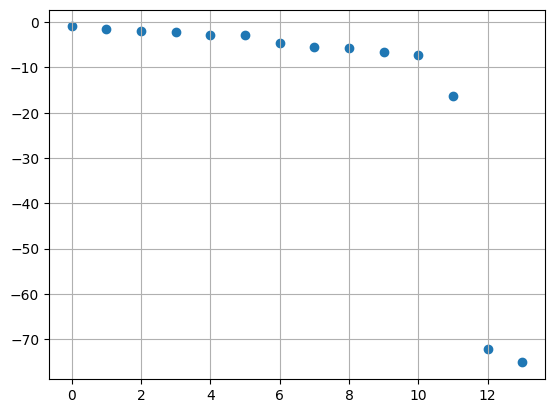

In [137]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

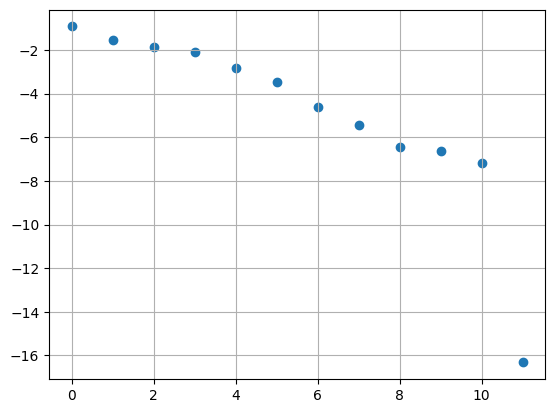

In [138]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

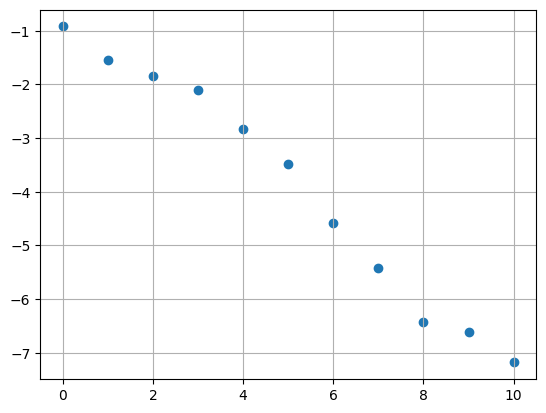

In [139]:
from matplotlib import pyplot as plt

plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
plt.grid()
# for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
#     plt.text(x,y,y)

### Finding the remaining algebraic relationships

In [125]:
from dae_finder import AlgModelFinder





from dae_finder import sequentialThLin, AlgModelFinder
seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


In [126]:
algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER/dae_finder.py:506: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x15adb7310>)

In [127]:
algebraic_model_th.best_models(5)

,x^2,y^2,d(x) /dt^2,y,d(y) /dt^2
x,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y,0.00000000,0.00000000,-12.28196994,NaN,-12.27219564
d(x) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
d(y) /dt,0.00000000,0.00000000,-0.60448385,0.00000000,-0.60426144
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x d(x) /dt,0.00000000,0.00000000,-7.38582699,0.00000000,-7.36393237
x d(y) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,-0.99995325,NaN,0.00000000,0.00000000,0.00000000
y d(x) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y d(y) /dt,0.00000000,0.00000000,-7.39015513,0.00000000,-7.36850051


In [128]:
seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.05)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= False)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x15ac0d7d0>)

In [129]:
algebraic_model_th.best_models(5)

,d(x) /dt^2,d(y) /dt^2,d(y) /dt,y,y^2
x,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y,-19.58825102,-19.54591865,-19.69551228,NaN,2.96767248
d(x) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
d(y) /dt,-0.95807255,-0.95607701,NaN,0.00000000,0.20310737
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x d(y) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,0.00000000,0.00000000,0.00000000,0.00000000,NaN
y d(x) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y d(y) /dt,0.00000000,0.00000000,0.00000000,0.00000000,-0.07804171
d(x) /dt d(y) /dt,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [98]:
0.99995441 - 0.99993971

1.4699999999923108e-05

<Axes: >

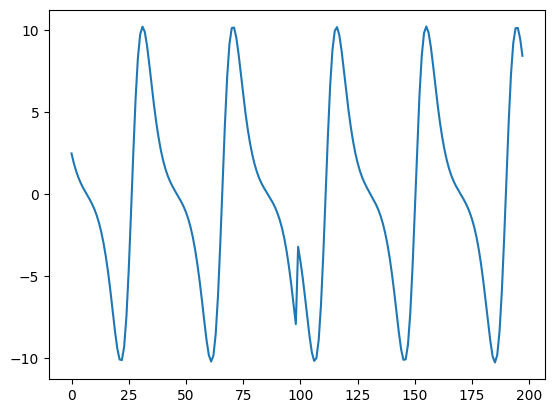

In [100]:
candidate_lib_full["d(y) /dt"].plot()

In [328]:
plt.plcandid_lib_comb["theta^2"]

0       5.55165247
1       5.55542013
2       5.55918253
3       5.56293967
4       5.56669154
           ...    
39991   2.90609055
39992   2.90025358
39993   2.89441579
39994   2.88857720
39995   2.88273781
Name: theta^2, Length: 39996, dtype: float64

In [130]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


algebraic_model_1.best_models(5)

,x^2,y^2,x d(x) /dt,y d(y) /dt,y
x,-0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
y,-0.00000000,0.00000000,0.00000000,0.00000000,NaN
d(x) /dt,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
d(y) /dt,-0.00000000,0.00000000,0.00000000,-0.00000000,-0.00000000
x y,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x d(x) /dt,-0.00000000,0.00000000,NaN,-0.66742455,0.00000000
x d(y) /dt,-0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000
y^2,-0.70000000,NaN,0.00000000,-0.00000000,0.00000000
y d(x) /dt,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000
y d(y) /dt,0.00000000,-0.00000000,-0.68237918,NaN,0.00000000


In [131]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
algebraic_model_1.fit(candidate_lib_full.drop(["x^2", "x d(x) /dt"], axis=1), scale_columns= True)


algebraic_model_1.best_models(5)

,y,d(x) /dt^2,d(y) /dt^2,y^2,y d(x) /dt
x,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000
d(x) /dt,-0.00000000,-0.00000000,0.00000000,0.00000000,-2.19224700
d(y) /dt,-0.00000000,-0.00000000,0.00000000,0.00000000,-0.00000000
x y,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
x d(y) /dt,0.00000000,-0.00000000,-0.00000000,0.00000000,-0.00000000
y^2,0.00000000,1.33057140,-2.13904257,NaN,0.00000000
y d(x) /dt,-0.00000000,-0.00000000,0.00000000,-0.00000000,NaN
y d(y) /dt,0.00000000,0.00000000,-0.00000000,-0.00000000,-0.00000000
d(x) /dt^2,-0.03213409,NaN,-0.00000000,0.02463479,-0.00000000
d(x) /dt d(y) /dt,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000


In [303]:
candidate_lib_full["y^2"]

0      12.50000000
1      12.50017149
2      12.50068595
3      12.50154339
4      12.50274378
           ...    
4985   24.49807736
4986   24.46559891
4987   24.43214638
4988   24.39772507
4989   24.36234043
Name: y^2, Length: 4990, dtype: float64

In [304]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["x^2"]], y=candidate_lib_full["y^2"])


LinearRegression()

In [305]:
lin_model.coef_
lin_model.intercept_

25.0

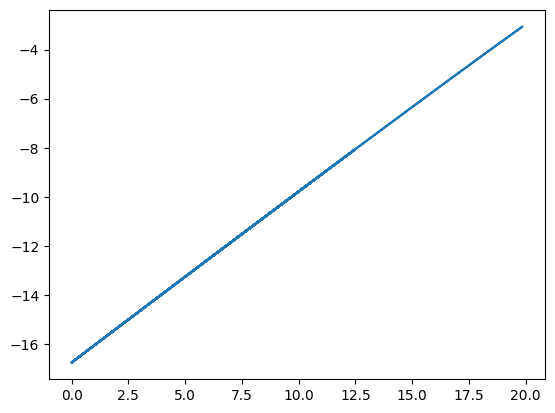

In [306]:
plt.plot(candidate_lib_full["x^2"], -0.7310178*candidate_lib_full["y^2"] + 0.41957709*-0.7310178*candidate_lib_full["y"])

In [94]:
(3/2)*np.pi

4.71238898038469

In [89]:
thet = (3/2)*np.pi
theta_dot = 6

0.5*(theta_dot)**2 + 9.81*(1-np.cos(thet))

27.810000000000002

In [90]:
thet = (3/2)*np.pi
theta_dot = -6

0.5*(theta_dot)**2 + 9.81*(1-np.cos(thet))

27.810000000000002

In [92]:
thet = -(3/2)*np.pi
theta_dot = 6

0.5*(theta_dot)**2 + 9.81*(1-np.cos(thet))

27.810000000000002

In [93]:
thet = -(3/2)*np.pi
theta_dot = -6

0.5*(theta_dot)**2 + 9.81*(1-np.cos(thet))

27.810000000000002

In [82]:
thet = 3/4*np.pi
theta_dot = 0

0.5*(theta_dot)**2 + 9.81*(1-np.cos(thet))

16.746717523440033

## Testing dynamics finding 

In [327]:
refined_candid_lib = candidate_lib_full.drop(['x^2'], axis=1)
# refined_candid_lib = candidate_lib_full.drop(['1'], axis=1)
# refined_candid_lib = pd.concat([refined_candid_lib, dummy_der[['d(omega) /dt']]], axis=1)

In [328]:
refined_candid_lib

,x,y,x y,y^2
0,3.53553391,-3.53553391,-12.50000000,12.50000000
1,3.53550965,-3.53555816,-12.50000000,12.50017149
2,3.53543690,-3.53563091,-12.49999998,12.50068595
3,3.53531563,-3.53575217,-12.49999990,12.50154339
4,3.53514586,-3.53592191,-12.49999970,12.50274378
...,...,...,...,...
4985,-0.70846499,-4.94955325,3.50658518,24.49807736
4986,-0.73102742,-4.94627121,3.61585987,24.46559891
4987,-0.75356063,-4.94288847,3.72476613,24.43214638
4988,-0.77606374,-4.93940534,3.83329339,24.39772507


## Refined candidate library is able to find the model 

In [329]:
data_matrix_df_appended["d(d(x) /dt) /dt"]

0      -4.90507851
1      -4.90527969
2      -4.90561247
3      -4.90608430
4      -4.90669107
           ...    
4985    2.95495231
4986    3.04328609
4987    3.13126390
4988    3.21887645
4989    3.30611451
Name: d(d(x) /dt) /dt, Length: 4990, dtype: float64

In [330]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=False, coef_threshold=0.2)

seq_th_model.fit(X=refined_candid_lib,  y=data_matrix_df_appended["d(d(x) /dt) /dt"])

Sequential threshold converged in 2 iterations


In [331]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': 0.9132255699505706, 'y': 0.0, 'x y': 0.7409365794371763, 'y^2': 0.0}

#### Using lasso

In [332]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)

In [333]:
from sklearn.linear_model import Lasso
alg_lasso = Lasso(fit_intercept=False, alpha=0.3)
alg_lasso.fit(X=refined_candid_lib,  y=data_matrix_df_appended["d(d(x) /dt) /dt"])

Lasso(alpha=0.3, fit_intercept=False)

In [334]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

{'x': 0.0, 'y': 0.0, 'x y': 0.49833581813778655, 'y^2': -0.004616722499338141}

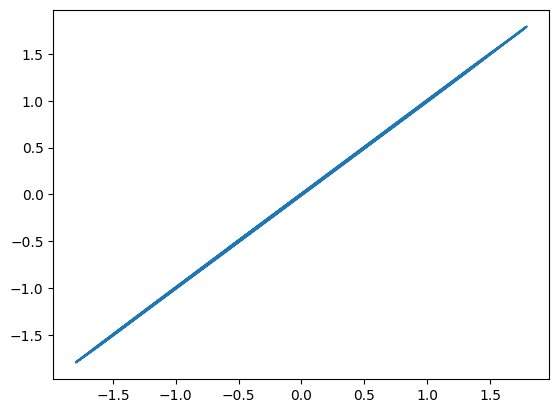

In [185]:
plt.plot(dummy_der["d(theta) /dt"], data_matrix_df_list[0]["omega"][:999])

<Axes: >

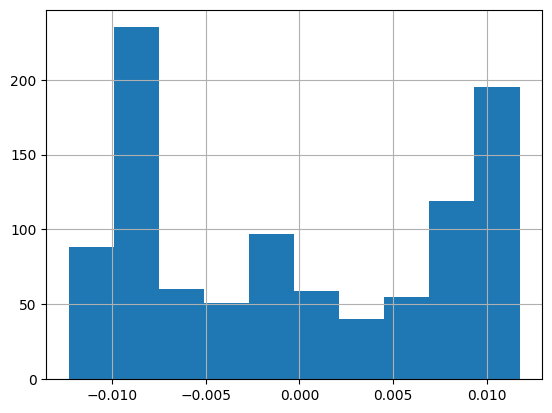

In [184]:
(dummy_der["d(theta) /dt"] - data_matrix_df_list[0]["omega"][:999]).hist()

<Axes: >

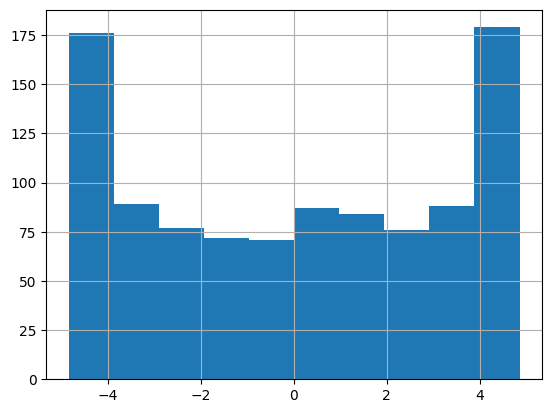

In [182]:
data_matrix_df_list[0]["u"][:999].hist()

In [31]:
pend_data.columns

Index(['t', 'x', 'y', nan], dtype='object', name=0)

In [37]:
pend_data = pd.read_csv("pendulum_data.txt")

pend_data.columns = pend_data.iloc[0]

pend_data = pend_data[1:]

pend_data = pend_data[list(pend_data.columns)[:-1]]

pend_data


,t,x,y
1,0.000000E0,1.235643E3,-7.171023E2
2,1.676118E-2,1.199471E3,-6.923710E2
3,3.352237E-2,1.199503E3,-6.922667E2
4,5.028355E-2,1.183921E3,-6.812947E2
5,6.704474E-2,1.170619E3,-6.695081E2
...,...,...,...
305,5.095400E0,1.351702E3,-8.083031E2
306,5.112161E0,1.382494E3,-8.103031E2
307,5.128922E0,1.382494E3,-8.103031E2
308,5.145684E0,1.414502E3,-8.123031E2


In [47]:
pend_data["t"] = pend_data["t"].apply(lambda x: float(x))
pend_data["x"] = pend_data["x"].apply(lambda x: float(x))
pend_data["y"] = pend_data["y"].apply(lambda x: float(x))


In [53]:
pend_data["theta"] = np.arctan(-pend_data["y"]/pend_data["x"])

248 evaluations required.


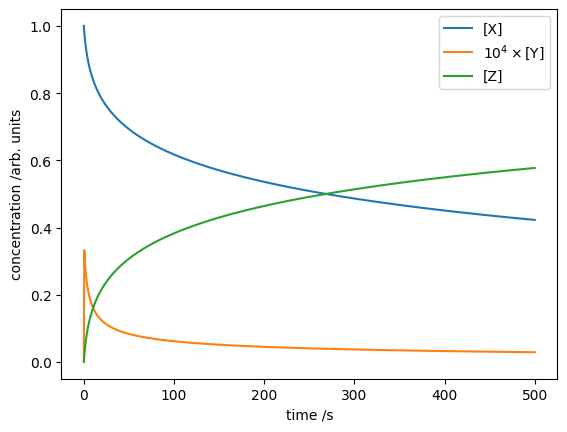

In [66]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def deriv(t, y):
    """ODEs for Robertson's chemical reaction system."""
    x, y, z = y
    xdot = -0.04 * x + 1.e4 * y * z
    ydot = 0.04 * x - 1.e4 * y * z - 3.e7 * y**2
    zdot = 3.e7 * y**2
    return xdot, ydot, zdot

# Initial and final times.
t0, tf = 0, 500
t_eval = np.linspace(t0, tf, 1000)
# Initial conditions: [X] = 1; [Y] = [Z] = 0.
y0 = 1, 0, 0
# Solve, using a method resilient to stiff ODEs.
soln = solve_ivp(deriv, (t0, tf), y0, method='Radau', t_eval=t_eval)
print(soln.nfev, 'evaluations required.')

# Plot the concentrations as a function of time. Scale [Y] by 10**YFAC
# so its variation is visible on the same axis used for [X] and [Z].
YFAC = 4
plt.plot(soln.t, soln.y[0], label='[X]')
plt.plot(soln.t, 10**YFAC*soln.y[1], label=r'$10^{}\times$[Y]'.format(YFAC))
plt.plot(soln.t, soln.y[2], label='[Z]')
plt.xlabel('time /s')
plt.ylabel('concentration /arb. units')
plt.legend()
plt.show()

In [70]:
dat_mat = pd.DataFrame(soln.y.T, columns=["x","y","z"])

In [68]:
dat_mat["x"] + dat_mat["y"] + dat_mat["z"]

0     1.00000000
1     1.00000000
2     1.00000000
3     1.00000000
4     1.00000000
         ...    
995   1.00000000
996   1.00000000
997   1.00000000
998   1.00000000
999   1.00000000
Length: 1000, dtype: float64

In [85]:
#Use lasso model by default
algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.5, fit_intercept=True)
algebraic_model_1.fit(dat_mat, scale_columns= True)


algebraic_model_1.best_models(5)

,x,z,y
y,0.00000000,-0.00000000,NaN
z,-0.49998589,NaN,-0.00000000
x,NaN,-0.50001411,0.00001260
r2- metric,0.75000000,0.75000000,0.56637324


In [79]:
from dae_finder import AlgModelFinder





from dae_finder import sequentialThLin, AlgModelFinder
seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold= 0.1)
algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)


algebraic_model_th.fit(dat_mat, scale_columns= True)


algebraic_model_th.best_models(5)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations


,x,z,y
y,0.00000000,0.00000000,NaN
z,-0.99897281,NaN,-0.00001419
x,NaN,-0.99902919,0.00001401
r2- metric,0.99999900,0.99999900,0.81637251


In [81]:
algebraic_model_th.fit(dat_mat, scale_columns= False)


algebraic_model_th.best_models(5)

Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER/dae_finder.py:506: UserWarning: All coefficients fell below threshold 0.1, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


,x,z,y
y,0.00000000,0.00000000,NaN
z,-0.92000557,NaN,0.00000000
x,NaN,-0.92010528,0.00000000
r2- metric,0.99360920,0.99360853,0.81495741


In [80]:
dat_mat.describe()

,x,y,z
count,1000.00000000,1000.00000000,1000.00000000
mean,0.54048627,0.00000516,0.45950858
std,0.10733061,0.00000335,0.10733364
min,0.42267931,0.00000000,0.00000000
25%,0.45856698,0.00000332,0.40836995
50%,0.50870068,0.00000404,0.49129528
75%,0.59162448,0.00000556,0.54142969
max,1.00000000,0.00003328,0.57731780
